# STATS 199 
***
### Examining Similarity of Online Publications with K-Means Clustering and PCA


In [6]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, SpectralClustering
from sklearn.feature_extraction.text import TfidfVectorizer
import datetime, re, rpy2
import pandas as pd
import numpy as np
from nltk.stem.snowball import EnglishStemmer
from sklearn.preprocessing import scale, StandardScaler, maxabs_scale

"""Attempts to load csv at `filename`, exits with non-zero status code if
fails. If optional `n_sample` argument is specified, randomly samples `n_sample`
rows and returns that DataFrame. Returns all rows by default.
"""
def load_dataset(filename, n_sample=None):
    try:
        df = pd.read_csv(filename)
        if n_sample:
            df = df.sample(n_sample)
        return df
    except FileNotFoundError:
        print("File not found!")
        exit(1)
    except Exception as e:
        print(str(e))
        exit(2)
""" By default, returns a DataFrame with all articles after the given date. If the optional
keyword argument `before` is true, returns all articles before the given date. Defaults to the
date of the inauguration.
"""
def filter_since(year=2017, day=20, month=1, before=False, to_csv=False):
    filenames = ["article_data/articles1.csv",
                 "article_data/articles2.csv",
                 "article_data/articles3.csv"]
    
    df = pd.DataFrame()
    try:
        new_df = pd.read_csv(filename)
    except FileNotFoundError:
        print("File {} not found. Skipping...".format(filename))
    df = df.append(new_df)
    del new_df

    dt = datetime.datetime(day=day, month=month, year=year)
    df['date'] = pd.to_datetime(df['date'], yearfirst=True)
    
    if before:
        df = df.loc[df.date <= dt]
    else:
        df = df.loc[df.date > dt]
    
    if to_csv:
        if before:
            df.to_csv("before_{}_{}_{}.csv".format(day, month, year))
        else:
            df.to_csv("after_{}_{}_{}.csv".format(day, month, year))
    return df

""" Returns articles from publications in `publications` (a list). 
If optional argument `filter_out` is True, filters returns articles NOT
in `publications`.
"""
def filter_publications(publications, filter_out=False, filename=None):
    print("Filtering out publications:")
    print(", ".join(publications))
    df = pd.DataFrame()
    if filename:
        filenames = [filename]
    else:
        filenames = ["article_data/articles1.csv",
                     "article_data/articles2.csv",
                     "article_data/articles3.csv"]
    for filename in filenames:
        try:
            new_df = pd.read_csv(filename)
        except FileNotFoundError:
            print("File {} not found. Skipping...".format(filename))
        if filter_out:
            f = lambda x: x.lower() not in [publication.lower() for publication in publications]
        else:
            f = lambda x: x.lower() in [publication.lower() for publication in publications]
            
        new_df = new_df.loc[new_df['publication'].apply(f)]
        print(new_df.head())
        df = df.append(new_df)
        del new_df
    for i in df.publication.unique().tolist():
        if filter_out:
            assert i not in publications
        else:
            assert i in publications
    return df


In [7]:
""" By default, returns a DataFrame with all articles after the given date. If the optional
keyword argument `before` is true, returns all articles before the given date. Defaults to the
date of the inauguration.
"""
def filter_since(year=2017, day=20, month=1, before=False, to_csv=False):
    filenames = ["article_data/articles1.csv",
                 "article_data/articles2.csv",
                 "article_data/articles3.csv"]
    
    df = pd.DataFrame()
    try:
        new_df = pd.read_csv(filename)
    except FileNotFoundError:
        print("File {} not found. Skipping...".format(filename))
    df = df.append(new_df)
    del new_df

    dt = datetime.datetime(day=day, month=month, year=year)
    df['date'] = pd.to_datetime(df['date'], yearfirst=True)
    
    if before:
        df = df.loc[df.date <= dt]
    else:
        df = df.loc[df.date > dt]
    
    if to_csv:
        if before:
            df.to_csv("before_{}_{}_{}.csv".format(day, month, year))
        else:
            df.to_csv("after_{}_{}_{}.csv".format(day, month, year))
    return df

""" Returns articles from publications in `publications` (a list). 
If optional argument `filter_out` is True, filters returns articles NOT
in `publications`.
"""
def filter_publications(publications, filter_out=False, filename=None):
    print("Filtering out publications:")
    print(", ".join(publications))
    df = pd.DataFrame()
    if filename:
        filenames = [filename]
    else:
        filenames = ["article_data/articles1.csv",
                     "article_data/articles2.csv",
                     "article_data/articles3.csv"]
    for filename in filenames:
        try:
            new_df = pd.read_csv(filename)
        except FileNotFoundError:
            print("File {} not found. Skipping...".format(filename))
        if filter_out:
            f = lambda x: x.lower() not in [publication.lower() for publication in publications]
        else:
            f = lambda x: x.lower() in [publication.lower() for publication in publications]
            
        new_df = new_df.loc[new_df['publication'].apply(f)]
        print(new_df.head())
        df = df.append(new_df)
        del new_df
    for i in df.publication.unique().tolist():
        if filter_out:
            assert i not in publications
        else:
            assert i in publications
    return df


In [8]:
stemmer = EnglishStemmer()

""" Compresses consecutive whitespace characters, tokenizes with whitespace 
as word break, and then stems each word. Returns joined words.

Returns NON-STEMMED TITLES BY DEFAULT
CURRENTLY NOT BEING USED
"""
def stem_words(sentence, do_not_stem=True):
    
    sentence = re.sub("[\s]+", " ", sentence)
    if do_not_stem:
        return sentence
    words = [stemmer.stem(word) for word in sentence.split(" ")]
    return " ".join(words)
    
""" Removes consecutive whitespace characters, removes common phrases (that are problematic
because all titles with that phrase become their own cluster) and certain unicode characters.
The incredibly long first argument to `re.sub` is because successive function calls removing
all these phrases in sequence took incredibly long; it's ugly, but necessary.
"""
def clean_title(sentence):
    sentence = re.sub("[\s]+", " ", sentence)
    sentence = re.sub("( - Breitbart)|([\s]+$)|(^[\s]+)|(as it happened)|(\u2019)|(\u2018)|(\u2013)|(\u201c)|(\u201d)|(\u00a0)|( - The New York Times)|(The Atlantic Politics & Policy Daily:)|(Fast Facts:)|(Your (Monday)?(Tuesday)?(Wednesday)?(Thursday)?(Friday)? Evening Briefing)|(The Atlantic Daily:)", " ", sentence)
    return sentence

""" Takes as input the initialized clustering class. 
`n_components` describes the number of principle components to use in the call to `get_pc`
`exclude` is an optional list of publications (as strings) 
to remove from the dataset before clustering. 
"""
def run_cluster(cluster_callable, filename, max_features, ngram_range, n_components=2, exclude=None, return_model=False):
    stemmer = EnglishStemmer()
    if exclude:
        data = filter_publications(exclude, filter_out=True, filename=filename)
    else:
        data = load_dataset(filename)
    data.dropna(subset=['content', 'title'], inplace=True)
    vec = TfidfVectorizer(stop_words='english',
                          ngram_range=ngram_range,
                          max_features=max_features)

    titles = data['title'].apply(lambda x: clean_title(x))
    transformed_docs = vec.fit_transform(titles)

    transformed_docs = transformed_docs
    scaled_docs = maxabs_scale(transformed_docs)
    clusters =  cluster_callable.fit_predict(scaled_docs)
    n_topics = pd.unique(clusters).size
    clusters_labels = [{'index': index.item(),
                        'cluster_label': cluster_label.item(),
                        'title': title,
                        'publication': publication} for index, cluster_label, title, publication in zip(np.arange(0, clusters.shape[0]), clusters, titles, data['publication'])]
    
    cluster_df = pd.DataFrame(clusters_labels)
    cluster_df.to_csv("clusters.csv")
    components = get_pc(cluster_df,
                        n_topics=n_topics,
                        n_components = n_components,
                        return_model=return_model)
    
    return components


***
## Grouping Publications with Principal Component Analysis
Next, we decompose the publication by cluster column feature matrix with Principal Component Analysis. This is a form of dimensionality reduction, and finds the lower-dimensional (given by n_components) subspace with the greatest variance. This means that we can reduce the dimensonality to either 2D or 3D along the axes that have the greatest spread, and plot it.

Because the articles are **not** a representative sample from these publications, both in volume of articles per period of time and in overall articles per publication, the decision was made to standardize the column vectors of the KMeans cluster matrix - that is, each topic should have the same amount of influence compared to the other vectors.

In [9]:
""" Returns `n_components` coefficients of first `n_components` principal component
basis vectors of column space of publication by cluster label count matrix, as well as
the unique publications, and optionally the PCA object itself.
That is, each row in the matrix is a different publication and each of the `n_topics` 
entries contains the count of its articles titles in that cluster. 
"""
def get_pc(df, n_topics, n_components, return_model=False):

    publications = pd.unique(df['publication'])
    init_matrix = np.zeros((publications.shape[0], n_topics))

    index_converter = {}
    for i,publication in enumerate(publications):
        index_converter[publication] = i

    for j in df.index:
        cluster = df.loc[j, 'cluster_label']
        init_matrix[index_converter[df.loc[j, 'publication']], cluster] += 1
    
    pca_model = PCA(n_components=n_components, svd_solver="randomized")
    
    scaled_matrix = scale(init_matrix, with_mean=True, with_std=False)
    
    components = pca_model.fit_transform(scaled_matrix)
    if return_model:
        return pca_model, components, publications
    return components, publications

### Why no unit variance normalization?
Normally, we do column normalization on the feature matrix before PCA so all columns are reduced to unit scale, such that every column has the same weight:

$$\tilde{x_{ij}} = \frac{x_{ij} - \bar{x_i}}{ s_i }$$

where:
- $\bar{x_i}$ is the sample mean of column $i$
- $s_i$ is the sample (unbiased) standard deviation of column $i$

However, since some columns (topics) might be more important in distinguishing different publications than others - in terms of their variance - we have made the conscious decision to not scale by the sample standard deviation and simply subtract the mean. This way, we avoid a common issue with PCA where the first principal component simply captures the mean of each feature column.

In [10]:
n_topics=75
n_components=4
model, matrix, publications = run_cluster(cluster_callable=KMeans(n_clusters=n_topics),
                                          filename="article_data/full_articles.csv", 
                                          max_features=1500,
                                          ngram_range=(1,3), 
                                          n_components=n_components,
                                          exclude=None,
                                          return_model=True)

if n_components == 2:
    col_names = ['first', 'second']
elif n_components == 3:
    col_names = ['first', 'second', 'third']
elif n_components == 4:
    col_names = ['first', 'second', 'third', 'fourth']

assert n_components >= 2 and n_components <= 4

daf = pd.DataFrame(matrix, columns=col_names)  
daf.to_csv("k{}.csv".format(n_topics))

In [11]:
from rpy2.robjects import numpy2ri, pandas2ri
numpy2ri.activate()
pandas2ri.activate()
rpy2.robjects.r['options'](warn=-1)
%load_ext rpy2.ipython
%R -i publications 
%R -i daf 

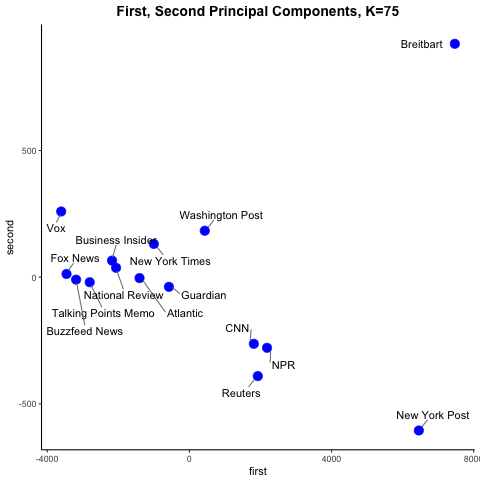

In [15]:
%%R 
library(ggplot2)
library(dplyr)
library(ggrepel)
library(plotly)

daf$publications = publications
graph = daf %>% 
        ggplot() +
        aes(x=first, y=second) +
        geom_point(size=4, shape=19, color="blue") +
        geom_text_repel(aes(label=publications),
                        box.padding=0.35,
                        point.padding=0.5,
                        segment.color='grey50') +
        theme_classic() +
        ggtitle('First, Second Principal Components, K=75') +
        theme(plot.title=element_text(hjust=0.5,
                                      size=14,
                                      face="bold"))
print(graph)

#plot_ly(daf, x=~first, y=~second, z=~third, text= ~ as.factor(publications)) %>% add_markers()

There's clearly something that hugely differentiates Breitbart and the New York Post from the rest of the publications. We can come up with reasons ourselves - for example, Breitbart seems to me infatuated with immigration - but we'll later determine exactly what that is. In any case, there is something hugely different about Breitbart that overrides everything else

For the time being, let's ignore it and focus on the differences between the rest of the news sources. We'll rerun everything from the beginning EXCLUDING Breitbart and the New York Post.

In [ ]:
n_topics=75
n_components=4
model, matrix, publications = run_cluster(cluster_callable=KMeans(n_clusters=n_topics),
                                          filename="article_data/full_articles.csv", 
                                          max_features=1500,
                                          ngram_range=(1,3), 
                                          n_components=4,
                                          exclude=["Breitbart", "New York Post"],
                                          return_model=True)

daf = pd.DataFrame(matrix, columns=['first', 'second', 'third', 'fourth'])  

In [ ]:
from rpy2.robjects import numpy2ri, pandas2ri
numpy2ri.activate()
pandas2ri.activate()
rpy2.robjects.r['options'](warn=-1)
%reload_ext rpy2.ipython
%R -i publications 
%R -i daf 

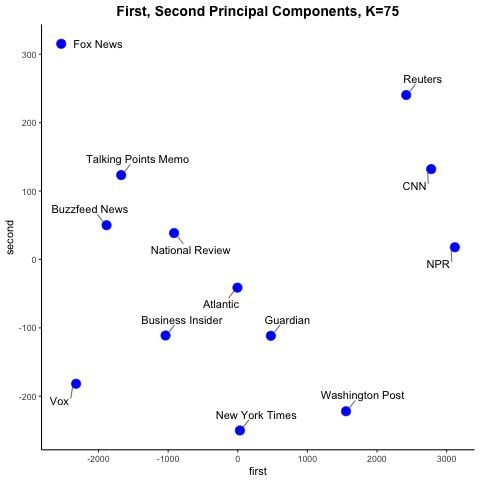

In [19]:
%%R 
library(ggplot2)
library(dplyr)
library(ggrepel)
library(plotly)

daf$publications = publications
graph = daf %>% 
        ggplot() +
        aes(x=first, y=second) +
        geom_point(size=4, shape=19, color="blue") +
        geom_text_repel(aes(label=publications),
                        box.padding=0.35,
                        point.padding=0.5,
                        segment.color='grey50') +
        theme_classic() +
        ggtitle('First, Second Principal Components, K=75') +
        theme(plot.title=element_text(hjust=0.5,
                                      size=14,
                                      face="bold"))
print(graph)

#plot_ly(daf, x=~first, y=~second, z=~third, text= ~ as.factor(publications)) %>% add_markers()

More to come!!